Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
# importing required libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## **Importing Skin Cancer Data**

In [2]:
## If we are using the data by mounting the google drive, we use the following code:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
## Defining the path for train and test images

root_path = "/content/gdrive/MyDrive/Data/CNN_assignment"
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [4]:
## Counting number of images in train and test directory

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Observation : This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

We are using 80% of the images for training, and 20% for validation.

In [6]:
## Loading train dataset
## We will use 80% of the images for training, and 20% for validation

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,labels='inferred', validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Loading validation dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,labels='inferred', validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
## List out all the classes of skin cancer and store them in a list. 

class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)
print(len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
9


### Visualize the data
#### We will visualize one instance of all the nine classes present in the dataset and show one random image from each class

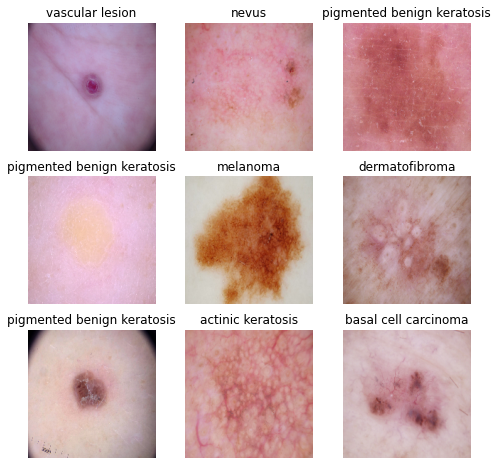

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the base model 
#### We will create base model without regularization but we will using optimiser
#### Rescaling to normalize pixel values between (0,1)
#### Model will contain 3 convolutional layers followed by max pooling layer, flattening layer and fully connected layer
 

In [11]:
## Normalisation layer to scale the RGB value between 0 and 1

preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [12]:
## defining the layer of CNN model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  ## 1st convolutional layer
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  ## 2nd convolutional layer
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  ## 3rd convolutional layer
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  ## Convert layer into 1-D
  layers.Flatten(),
  ## Fully connected layer
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
# Compile the model using adam optimizer
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
## Viewing the summary 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [15]:
## training model for 20 epochs

epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 221s 906ms/step - loss: 2.0556 - accuracy: 0.2154 - val_loss: 1.8917 - val_accuracy: 0.3221
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.7729 - accuracy: 0.3599 - val_loss: 1.5740 - val_accuracy: 0.4653
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6637 - accuracy: 0.3940 - val_loss: 1.6091 - val_accuracy: 0.4340
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4156 - accuracy: 0.5117 - val_loss: 1.4052 - val_accuracy: 0.5302
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3653 - accuracy: 0.5234 - val_loss: 1.3837 - val_accuracy: 0.5391
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3029 - accuracy: 0.5474 - val_loss: 1.4515 - val_accuracy: 0.4720
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1836 - accuracy: 0.5765 - val_loss: 1.3860 - val_accuracy: 0.5011
Epoch 8/20

### Visualizing training results

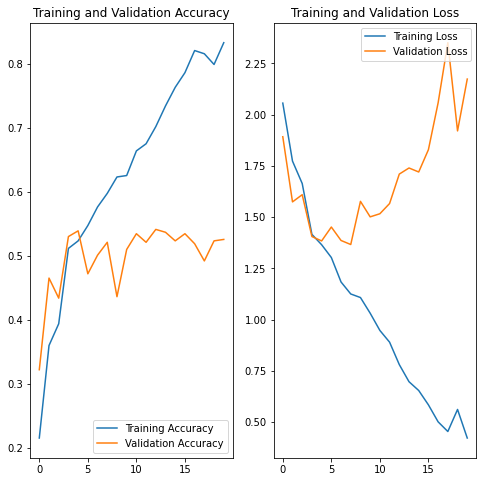

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observation : The difference between training and validation accuracy is higher and this is the sign of overfitting. The training accuracy is 83.31% while the validation accuracy is 52.57% which is clearly the sign of overfitting. From the above loss diagram, we can see that the training loss is decreasing continuously with each epoch with it's learning but validation loss is decreasing at first few epoch then it started increasing which shows that the loss has increased during the testing  on validation set. To tackle such situation we will use data augmentation. .

### Data Augumentation

In [17]:
## Defining the data augementation pipeline

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

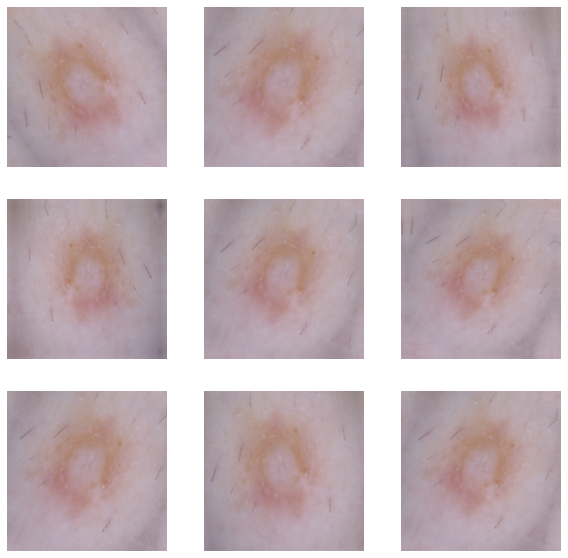

In [18]:
##  To visualize augmentation strategy we will visualise one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create the model, compile and train the model
### Model will have 3 convolutional layers followed by max pooling layer. This will be followed by flattening layer and fully connected layer. We will also use dropout of 0.2 or 20%in order to reduce overfitting of our model.




In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [20]:
## Compile the model using adam optimizer

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
# viewing model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [22]:
## training our model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 3s 45ms/step - loss: 2.0607 - accuracy: 0.2143 - val_loss: 1.9051 - val_accuracy: 0.3289
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.8209 - accuracy: 0.3588 - val_loss: 1.6755 - val_accuracy: 0.4295
Epoch 3/20
56/56 [==============================] - 2s 41ms/step - loss: 1.6586 - accuracy: 0.4035 - val_loss: 1.5963 - val_accuracy: 0.4340
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.5708 - accuracy: 0.4291 - val_loss: 1.4788 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4312 - accuracy: 0.4967 - val_loss: 1.4145 - val_accuracy: 0.5145
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3345 - accuracy: 0.5318 - val_loss: 1.3429 - val_accuracy: 0.5481
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.2793 - accuracy: 0.5435 - val_loss: 1.3044 - val_accuracy: 0.5526
Epoch 8/20
56

### Visualizing the results

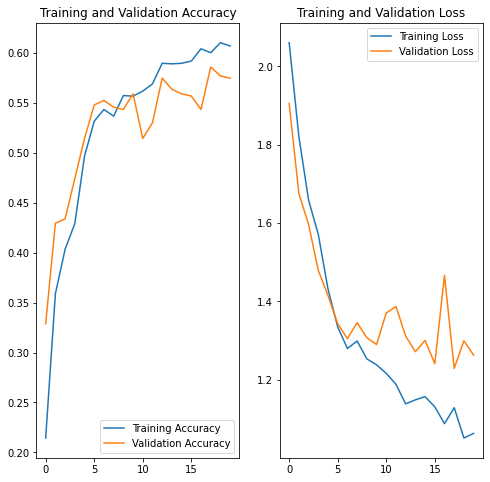

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Observation : Applying data augmentation and Dropout of 0.2, there is less sign overfitting than before.Training accuracy is 60.71%, Validation accuracy  57.49%. The above result shows data augmentation solve our problem of overfitting.

## Class imbalance
### Find the distribution of classes in the training dataset.

<Figure size 720x720 with 0 Axes>

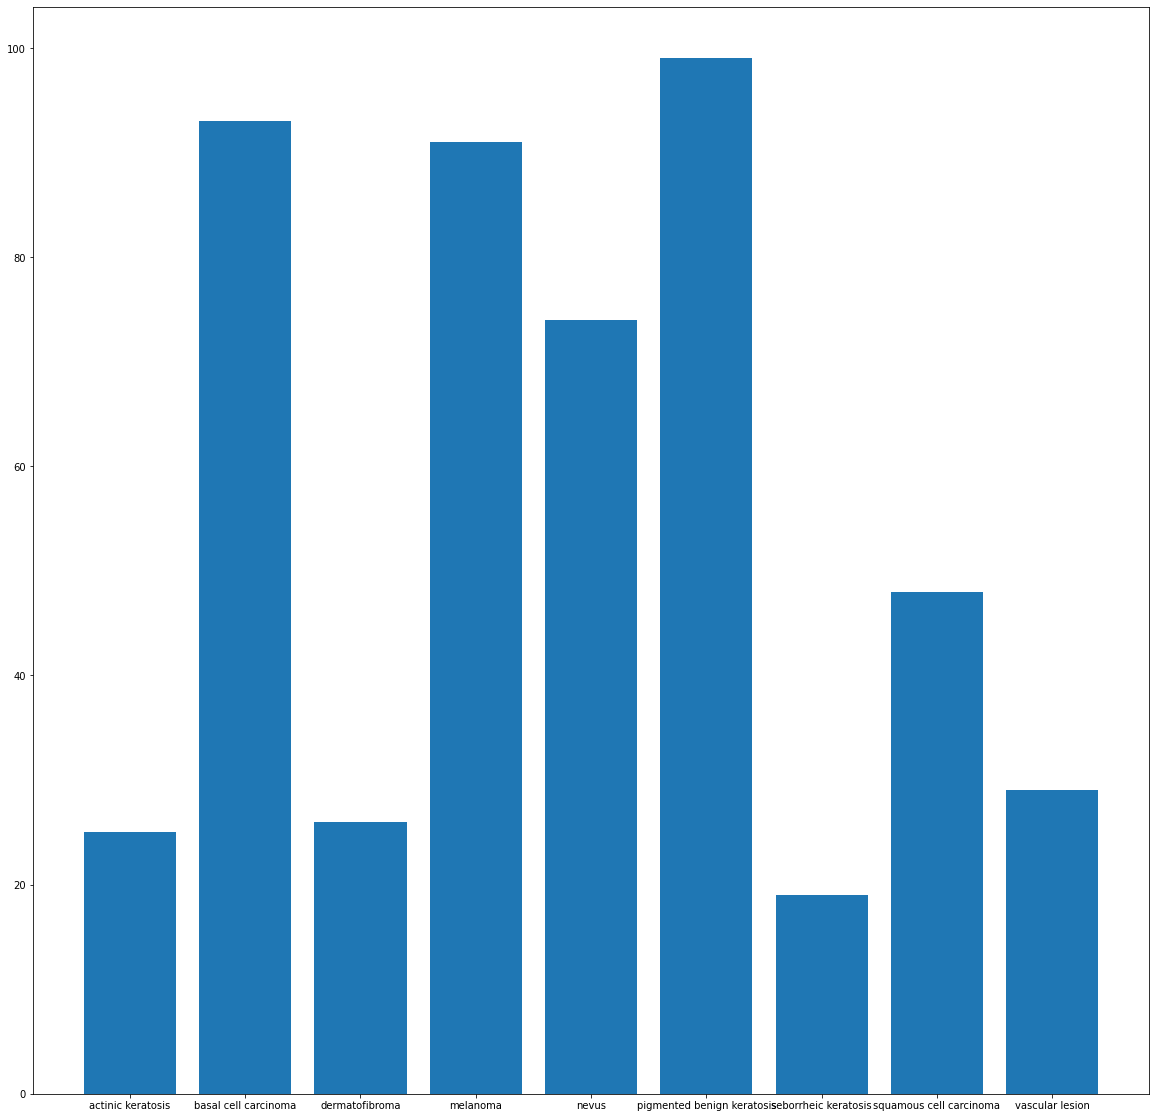

In [24]:
## distribution of the number of images for each label

import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()

#### seborrhetic keratosis class has least number of samples
#### melanoma, pigmented benign keratosis, basal cell carcinoma, nevus classes are dominating in data sets
#### We can clearly observe class imbalance in the dataset which can effect our model. We will rectify class imbalances by Augmentor


In [25]:
# install Augmentor is necessary

!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
## To use `Augmentor`, the following general procedure is followed:

# 1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.
# 2. Define a number of operations to perform on this data set using your `Pipeline` object.
# 3. Execute these operations by calling the `Pipeline’s` `sample()` method.


path_to_training_dataset="/content/gdrive/MyDrive/Data/CNN_assignment/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/CNN_assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8A4A0CF7F0>: 100%|██████████| 500/500 [00:21<00:00, 22.83 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/CNN_assignment/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8A4E094370>: 100%|██████████| 500/500 [00:23<00:00, 20.92 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/CNN_assignment/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8A4E32FC40>: 100%|██████████| 500/500 [00:19<00:00, 26.07 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/CNN_assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8A4A16A1F0>: 100%|██████████| 500/500 [01:32<00:00,  5.42 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/CNN_assignment/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F8A66209BB0>: 100%|██████████| 500/500 [01:28<00:00,  5.62 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/CNN_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8A4A15A9D0>: 100%|██████████| 500/500 [00:20<00:00, 23.87 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/CNN_assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8AD6D27280>: 100%|██████████| 500/500 [00:43<00:00, 11.45 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/CNN_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8AC8A85AC0>: 100%|██████████| 500/500 [00:19<00:00, 26.18 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data/CNN_assignment/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F8AC8BD6F70>: 100%|██████████| 500/500 [00:18<00:00, 26.98 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
## Count of image

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### find the distribution of augmented data after adding new images to the original training data.

In [28]:
## List of path of files in the training directory having agumented images as well

from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/Data/CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0010137.jpg_da577109-80f0-4fb0-89a3-6de70c16a162.jpg',
 '/content/gdrive/MyDrive/Data/CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0010655.jpg_b5032777-0aa9-4684-8b5e-939e20551040.jpg',
 '/content/gdrive/MyDrive/Data/CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0010000.jpg_ebcbc42b-55d6-44e1-abf4-f775b148d8c2.jpg',
 '/content/gdrive/MyDrive/Data/CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0010397.jpg_9ce089f5-2d31-49d3-8eaa-b319de8ddee7.jpg',
 '/content/gdrive/MyDrive/Data/CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0009950.jpg_e2f985b0-1890-4984-ad3e-0ec0952026f3.jpg',
 '/content/gdrive/MyDrive/Data/CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0010784.jpg_049847da-b64d-44af-88af-22108c364bc2.jpg',
 '/content/gdrive/MyDrive/Data/CNN_assignment/Train/melanoma/output/melanoma_original_ISIC_0010754.jpg_c4fff95d-162e-422d-b6

In [29]:
## List of path of files in the training directory

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [30]:
## Building a dictorary of path and labels

dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [31]:
## Creating dataframe of the above dictionary

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
new_df = (df2)

In [32]:
## Count of each classes after solving the problem of class imbalance

new_df['Label'].value_counts()

melanoma                      500
pigmented benign keratosis    500
actinic keratosis             500
vascular lesion               500
nevus                         500
basal cell carcinoma          500
seborrheic keratosis          500
squamous cell carcinoma       500
dermatofibroma                500
Name: Label, dtype: int64

We added 500 images in each class in order to maintain class balance. 

#### Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [34]:
## Load the train dataset
## We will use 80% of the images for training, and 20% for validation

data_dir_train="/content/gdrive/MyDrive/Data/CNN_assignment/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [35]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create our model.
#### Model will contain 3 convolutional layer followed by max pooling layer, flattening layer and fully connected layer.
#### We will also use BatchNormalisation and dropout to reduce overfitting.


In [36]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),

  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
  

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),
 

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  
  layers.Dropout(0.2),

  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),

  layers.Dense(num_classes)
])

### Compile the model
##### We have chosen Adam optimiser and SparseCategoricalCrossentropy loss function for model training.

In [37]:
## Compile our model 

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

In [38]:
# Viewing model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

#### **Todo:**  Train your model

In [39]:
## Training our model on 30 epochs

epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 46s 257ms/step - loss: 1.6950 - accuracy: 0.3678 - val_loss: 2.7684 - val_accuracy: 0.1990
Epoch 2/30
169/169 [==============================] - 37s 208ms/step - loss: 1.4905 - accuracy: 0.4549 - val_loss: 1.9128 - val_accuracy: 0.3571
Epoch 3/30
169/169 [==============================] - 36s 204ms/step - loss: 1.4095 - accuracy: 0.4696 - val_loss: 1.7304 - val_accuracy: 0.3868
Epoch 4/30
169/169 [==============================] - 35s 203ms/step - loss: 1.3731 - accuracy: 0.4811 - val_loss: 1.6899 - val_accuracy: 0.3764
Epoch 5/30
169/169 [==============================] - 35s 202ms/step - loss: 1.3312 - accuracy: 0.5032 - val_loss: 1.5594 - val_accuracy: 0.4573
Epoch 6/30
169/169 [==============================] - 38s 218ms/step - loss: 1.2924 - accuracy: 0.5108 - val_loss: 1.7192 - val_accuracy: 0.4224
Epoch 7/30
169/169 [==============================] - 35s 201ms/step - loss: 1.2534 - accuracy: 0.5302 - val_loss: 1.6718 - val_ac

#### Visualize the model results

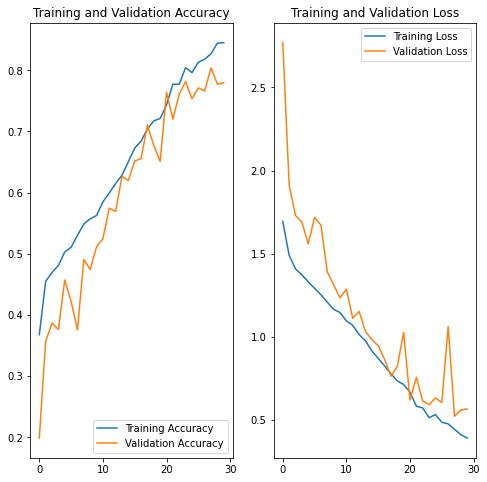

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
##### Accuracy on training data has increased by using Augmentor library. The training accuracy is 84.51% and validation accuracy is 77.95% which shows us we finally tackle the problem of overfitting. 
##### After solving class imbalance problem, tuning the learning rate, the accuracy has increases significantly and also handle model overfitting problem. 



In [41]:
data_dir_test = "/content/gdrive/MyDrive/Data/CNN_assignment/Test/"

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=batch_size
)
print(test_ds.class_names)

normalised_layer = tf.keras.layers.Rescaling(1./255)
test_ds1 = test_ds.map(lambda x, y: (normalised_layer(x), y))

model.evaluate(test_ds1)

Found 118 files belonging to 9 classes.
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
4/4 [==============================] - 19s 60ms/step - loss: 10.5385 - accuracy: 0.0254


[10.538475036621094, 0.025423727929592133]